# Pre-Workout

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
import keras
import numpy as np
import PIL
from PIL import Image
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from scipy.spatial import distance
import random
import utils

In [8]:
def create_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding = 'same', input_shape=input_shape + (3,)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), padding = 'same', strides = 2))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), padding = 'same', strides = 2))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), padding = 'same', strides = 2))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), padding = 'same', strides = 2))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling2D())

    model.add(Dense(101)) # 101 number of classes
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=['accuracy'])

    return model

# Dataset for training 

In [6]:
TRAINING_PATH = "/datasets/animali/unbalanced_dataset_2304 2/training/"
train_data_dir = TRAINING_PATH
target_shape = (256, 256)
# validation_data_dir = TRAINING_PATH

epochs = 100
batch_size = 16
lr = 0.001

nb_train_samples = 26434 # number of training images * 0.8
nb_validation_samples = 6570 # number of validation images * 0.2

In [7]:


# data generator
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range=0.2, #apply shear mapping
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # !!!

# training set generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    subset='training')

#validation set generator
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False,
    subset='validation')

Found 17605 images belonging to 101 classes.
Found 4394 images belonging to 101 classes.


#  CNN model

## create

In [9]:
model = create_model(target_shape)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) # stop the training if loss has not improved for 5 epochs
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/saved_models/CNN_Keras_1/checkpoints/victor_CNN_droput_Adam_default_lowdataaugm.hdf5', verbose=1, save_best_only=True)


## Training

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9

In [ ]:
 model.fit(
     train_generator,
     steps_per_epoch=nb_train_samples // batch_size,
     epochs=epochs,
     callbacks=[early_stop, checkpointer],
     validation_data=validation_generator,
     validation_steps=nb_validation_samples // batch_size
     )

Epoch 1/100
  19/1652 [..............................] - ETA: 9:23 - loss: 4.6976 - accuracy: 0.0197

KeyboardInterrupt: ignored

## save model

In [ ]:
#model.save_weights('/content/drive/MyDrive/saved_weights/CNN_Keras_1/unbalanced_victor_adam_default_nodropout_ligthdataaug.h5') ## change
MODEL_SAVE_PATH = '/content/drive/MyDrive/saved_models/CNN_Keras_1/unbalanced_victor_adam_default_nodropout_ligthdataaug.h5'
model.save(MODEL_SAVE_PATH)


## Load saved model

In [ ]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/models/Sandro_CNN_low_data_aug_Victor.h5'
model = keras.models.load_model(MODEL_SAVE_PATH)

## Create feature extractor

In [12]:
feat_extractor = Model(inputs= model.input, outputs=model.get_layer('global_average_pooling2d').output) # we get the 256




# Evaluation

## methods

In [ ]:
def display_results(query_item, results):
    image_string = tf.io.read_file(query_item)
    #image = tf.image.decode_jpeg(image_string, channels=1)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)



    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, cmap=plt.cm.binary)
    plt.grid(False)
    plt.title(str(next((i for i, x in enumerate(results[query_item]) if query_labels[query_item] == gallery_labels[x]), 10)+1) + query_labels[query_item])

    plt.figure(figsize=(10,10))
    for i, gallery_item in enumerate(results[query_item]):
        plt.subplot(4,4,i+1)
        image_string = tf.io.read_file(gallery_item)
        image = tf.image.decode_jpeg(image_string, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, target_shape)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image, cmap=plt.cm.binary)
        plt.grid(False)
        plt.title(gallery_labels[gallery_item] )#+ round(simi[0],2)



## dataset

In [13]:
GALLERY_PATH = "/datasets/animali/unbalanced_dataset_2304 2/validation/gallery/"
QUERY_PATH = "/datasets/animali/unbalanced_dataset_2304 2/validation/query/"

In [16]:

gallery_ds = utils.Dataset(data_path=GALLERY_PATH, target_shape= target_shape)
query_ds = utils.Dataset(data_path=QUERY_PATH, target_shape= target_shape)

gallery = gallery_ds.get_dataset()
query = query_ds.get_dataset()



Loaded 120 images from /datasets/animali/unbalanced_dataset_2304 2/validation/gallery/ 
Loaded 33 images from /datasets/animali/unbalanced_dataset_2304 2/validation/query/ 


In [18]:
gallery_features, gallery_urls, gallery_labels = utils.compute_features(gallery, feat_extractor)
query_features, query_urls, query_labels = utils.compute_features(query, feat_extractor)
results = compute_results(query_features, gallery_features, query_urls, gallery_urls)
evaluate(results, query_labels, gallery_labels)

ResourceExhaustedError: OOM when allocating tensor with shape[64,256,256,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

{1: 49, 3: 72, 5: 89, 10: 125, 11: 259} no train 

In [ ]:
ev, err =  evaluate(results)
it = iter(err)


## display errors

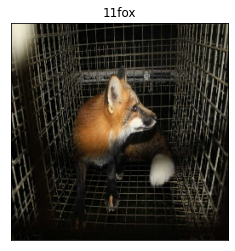

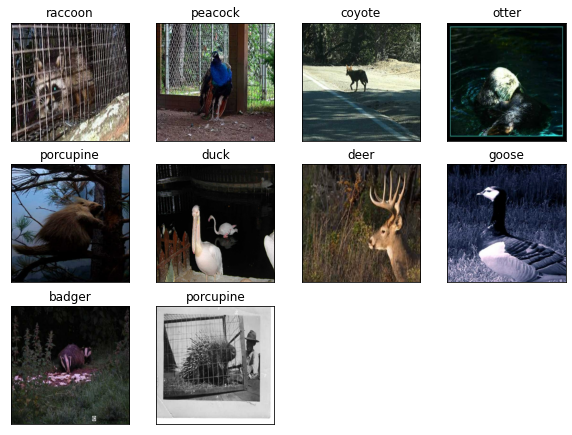

In [ ]:
query_item = next(it)
utils.display_results(query_item, results)

# TODO: different distance functions

In [ ]:
def get_closest_images_cosine(query_image_idx, num_results=10):
    distances = [ distance.cosine(query_features[query_image_idx], feat) for feat in gallery_features]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[:num_results]
    return idx_closest

def get_closest_images_euclidean(query_image_idx, num_results=10):
    distances = [ distance.euclidean(query_features[query_image_idx], feat) for feat in gallery_features]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[:num_results]
    return idx_closest

def get_closest_images_chebyshev(query_image_idx, num_results=10):
    distances = [ distance.chebyshev(query_features[query_image_idx], feat) for feat in gallery_features]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[:num_results]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


In [ ]:
def get_closest_dict(query_images, gallery_images, distance = 'cosine'):
  res = {}
  for i in range(len(query_images)):

    if distance == 'chebyshev':
      idx_closest = get_closest_images_chebyshev(i)
    elif distance == 'euclidean':
      idx_closest = get_closest_images_euclidean(i)
    else:
      idx_closest = get_closest_images_cosine(i)
      
    closest_images_list = [gallery_images[idx] for idx in idx_closest]
    res[query_images[i]] = closest_images_list

  return res

In [ ]:
dizionario = get_closest_dict(query_images[:100], gallery_images, 'cosine')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=93aceac2-8452-469e-8b02-c16d0438aa9c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>